# <span style="color:navy">IBM Capstone Project (On-Going Project)</span>

This project is being completed as Part of the IBM Data Science Professional Certification. 

# Stage 1
---

There are a total of 56 postal codes in Glasgow. In the first stage of this project, The postal codes for the possible venues are narrowed down based on four criteria. The criteria is as follows

Final Post codes must 
- be within 5 km of the city center
- have good transport accessibility (must be within 2 km of a subway station)
- have a high population
- have high population diversity 

In [1]:
# Defining the Search Paramenter variables
Distance_from_city_center = 5 #In Km
Distance_from_Subway_station = 2 #In Km

### 1.1 Scraping the Glasgow Postal Addresses from Wikipedia

In [2]:
#Importing the Libraries   
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [3]:
#Scraping data from web and saving into pandas dataframe
res = requests.get("https://en.wikipedia.org/wiki/G_postcode_area")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[1]
df = pd.read_html(str(table))
Glasgow_df=pd.DataFrame(df[0])
Glasgow_df.head()

Postcode district Post town  \
0                G1   GLASGOW   
1                G2   GLASGOW   
2                G3   GLASGOW   
3                G4   GLASGOW   
4                G5   GLASGOW   

                                            Coverage Local authority area  
0                  Former C1 district: Merchant City         Glasgow City  
1  Former C2 district: Blythswood Hill, Anderston...         Glasgow City  
2  Former C3 district: Anderston, Finnieston, Gar...         Glasgow City  
3  Former C4 district: Calton (part), Cowcaddens ...         Glasgow City  
4                        Former C5 district: Gorbals         Glasgow City

In [4]:
#Printing the shape of the data frame before Preprocessing 
print(Glasgow_df.shape)

(56, 4)


There are a total of <span style="color:maroon">**56**</span> G postal codes.

###  1.2 Prepossing of the Data

In this step, the data in the dataframe is processed in order to remove invalid entries. This reduces the data frame to 50 entries.Information about the former districts is removed from the coverage column. A new column is also added to the dataframe. This column contains the first coverage entry. This new column is called 'District'. This column will later will be used to find the coordinates of the Postal code. 

In [5]:
# Droping the entries where the Local authority area is not defined
Glasgow_df=Glasgow_df[Glasgow_df['Local authority area'] != 'non-geographic']
Glasgow_df= Glasgow_df[Glasgow_df['Postcode district']!='G51 2']
Glasgow_df=Glasgow_df.reset_index(drop=True,inplace=False)
Glasgow_df['Postcode district']= Glasgow_df['Postcode district'].str.rsplit(" ", n =0 , expand = False).str[0]
Glasgow_df.head()

Postcode district Post town  \
0                G1   GLASGOW   
1                G2   GLASGOW   
2                G3   GLASGOW   
3                G4   GLASGOW   
4                G5   GLASGOW   

                                            Coverage Local authority area  
0                  Former C1 district: Merchant City         Glasgow City  
1  Former C2 district: Blythswood Hill, Anderston...         Glasgow City  
2  Former C3 district: Anderston, Finnieston, Gar...         Glasgow City  
3  Former C4 district: Calton (part), Cowcaddens ...         Glasgow City  
4                        Former C5 district: Gorbals         Glasgow City

In [6]:
#Printing the shape of the new data frame
print(Glasgow_df.shape)

(50, 4)


In [7]:
# Removing the former district information from the Coverage column 
for n in range (Glasgow_df.shape[0]):
    if ': ' in Glasgow_df['Coverage'][n]:
        t=Glasgow_df['Coverage'][n]
        Glasgow_df['Coverage'][n]=t.split(': ',2)[1]
Glasgow_df.head()

Postcode district Post town  \
0                G1   GLASGOW   
1                G2   GLASGOW   
2                G3   GLASGOW   
3                G4   GLASGOW   
4                G5   GLASGOW   

                                            Coverage Local authority area  
0                                      Merchant City         Glasgow City  
1                  Blythswood Hill, Anderston (part)         Glasgow City  
2  Anderston, Finnieston, Garnethill, Park, Woodl...         Glasgow City  
3  Calton (part), Cowcaddens (part), Drygate, Kel...         Glasgow City  
4                                            Gorbals         Glasgow City

In [8]:
# Forming a new Column called District which is the first area in the coverage column (This will be used to find the Latitude and Longitude Information)  
Glasgow_df['District']= Glasgow_df['Coverage'].str.rsplit(",", n =0 , expand = False).str[0] 
Glasgow_df['District']= Glasgow_df['District'].str.rsplit("(", n =0 , expand = False).str[0]
Glasgow_df['District'][47]='Hardgate'

In [9]:
#Printing the Entire Data Frame
Glasgow_df.shape

(50, 5)

### 1.3 Finding the Latitude and Longitude Information for all the G Postal codes

For the remaining valid postcode entries, Foursquare is used to find the coordinates (latitude and longitude) of each of the post codes. The following code is used. It uses the Nominatim library. The postal codes are found be feedind an address to the geolocator.geocode function. The input of the function is the Postal code and District Information from the Data Frame. All the Postal addressess are manually saved in a csv file named **Postcode_Glasgow_Longitude_Latitude_Data** in the Excel_Data Folder. This file is read and saved into a data frame that is then merged with the data frame scraped form the web.    

(The code):

    from geopy.geocoders import Nominatim
    for n in range (0,Glasgow_df.shape[0]):
        address = '{}, {}, Glasgow'.format(Glasgow_df['Postcode district'][n], Glasgow_df['District'][n])
        geolocator = Nominatim(user_agent="foursquare_agent")
        location = geolocator.geocode(address)
        latitude=location.latitude
        longitude=location.longitude
        print('Index:',n,'{},{} has latitude='.format(Glasgow_df['Postcode district'][n], Glasgow_df['District'][n]),latitude,'and longitide=', longitude)

In [10]:
#The csv file is read and saved in a data frame
Glasgow_df_latlng = pd.read_csv('Excel_Data/Postcode_Glasgow_Longitude_Latitude_Data.csv', index_col=0)
print ('Data read into a pandas dataframe!')

Data read into a pandas dataframe!


In [11]:
#The Data is processed to add index values 
Glasgow_df_latlng.columns = list(map(str, Glasgow_df_latlng.columns))
Glasgow_df_latlng.reset_index(level=0, inplace=True)
Glasgow_df_latlng.head()

Postcode district   Latitude  Longitude
0                G1  55.859126  -4.246316
1                G2  55.863319  -4.261671
2                G3  55.859699  -4.271292
3                G4  55.853724  -4.232824
4                G5  55.851813  -4.253163

In [12]:
#The Glasgow_df and the Glasgow_df_latlng datasets are merged 
Glasgow = pd.merge(Glasgow_df, Glasgow_df_latlng, on='Postcode district')

In [13]:
#Displaying the entire dataset
Glasgow.head()

Postcode district Post town  \
0                G1   GLASGOW   
1                G2   GLASGOW   
2                G3   GLASGOW   
3                G4   GLASGOW   
4                G5   GLASGOW   

                                            Coverage Local authority area  \
0                                      Merchant City         Glasgow City   
1                  Blythswood Hill, Anderston (part)         Glasgow City   
2  Anderston, Finnieston, Garnethill, Park, Woodl...         Glasgow City   
3  Calton (part), Cowcaddens (part), Drygate, Kel...         Glasgow City   
4                                            Gorbals         Glasgow City   

          District   Latitude  Longitude  
0    Merchant City  55.859126  -4.246316  
1  Blythswood Hill  55.863319  -4.261671  
2        Anderston  55.859699  -4.271292  
3          Calton   55.853724  -4.232824  
4          Gorbals  55.851813  -4.253163

### 1.4 Plotting the Postal Codes on a Map

All the 50 postal codes are pltted on a map to visualize their geographical distribution. The Folium library is used to plot the map.

In [14]:
# Importing the Libraries 
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim 
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium
from folium import IFrame
import numpy as np

Finding the Coordinates of Glasgow City to center the map:

    address = 'Glasgow, UK'
    geolocator = Nominatim(user_agent="t_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of Glasgow, UK are {}, {}.'.format(latitude, longitude))

In [15]:
#Coordinates of Glasgow City Center
latitude = 55.8609825
longitude = -4.2488787

In [16]:
# create map of Glasgow using latitude and longitude values to show all the Postal Codes
map_Glasgow = folium.Map(location=[latitude, longitude], zoom_start=9.5)
for lat, lng, post in zip(Glasgow['Latitude'], Glasgow['Longitude'], Glasgow['Postcode district']):
    label = 'Postal Code: {}'.format(post)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='purple',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Glasgow)  

text = 'City Center of Glasgow'
iframe = folium.IFrame(text, width=200, height=25)
popup = folium.Popup(iframe, max_width=3000)
Text = folium.Marker(location=[55.8609825,-4.2488787], popup=popup)
map_Glasgow.add_child(Text)

map_Glasgow

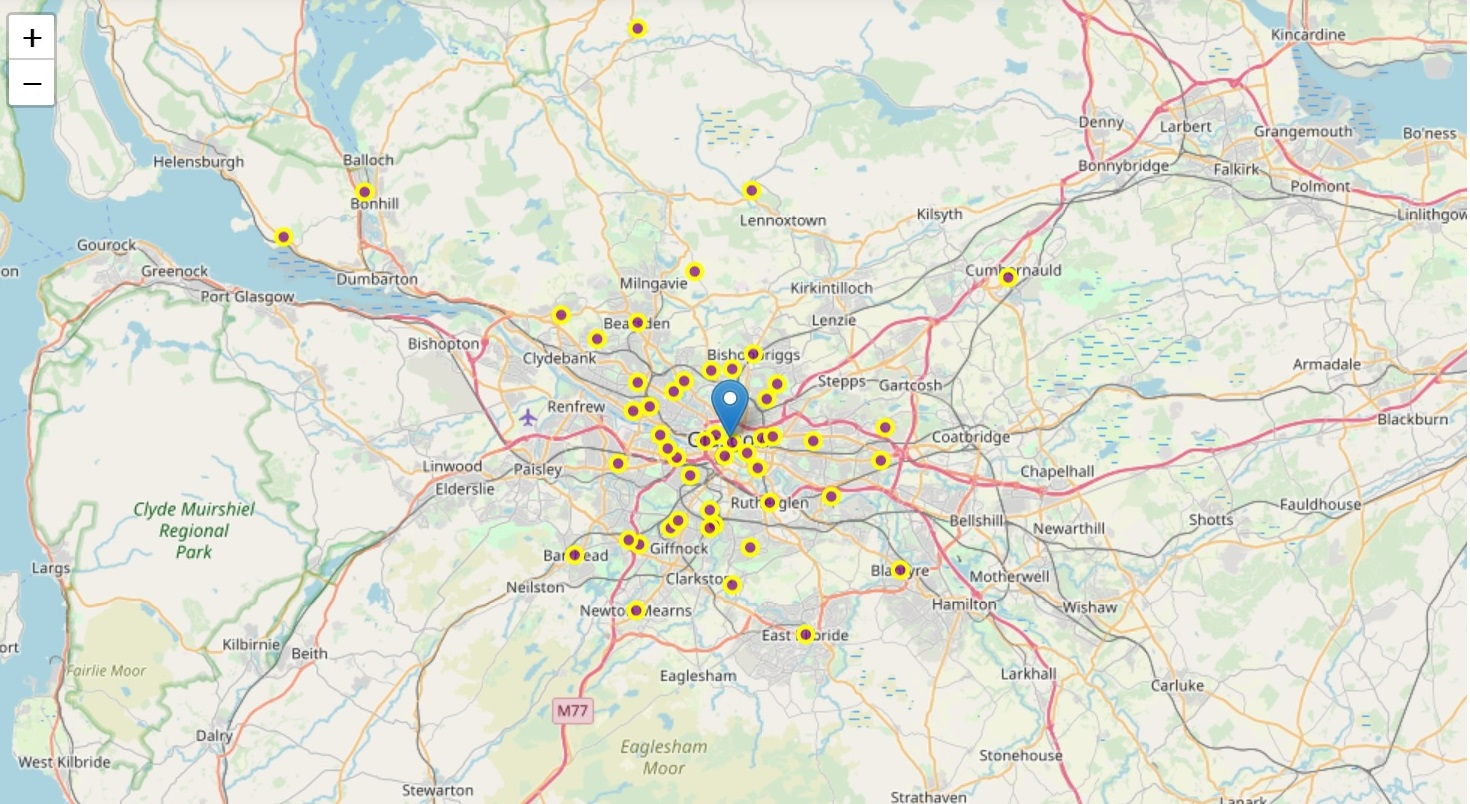

In [17]:
from IPython.display import Image
Image("Images/Glasgow_AllPostcodes.jpg")

As it can be seen from the Map Above, the Postal codes are spread over a very large area. Therefore in order to focus the analysis the postal codes near the City Center (within 5 km) are considered.

## <span style="color:maroon">1.5 Criteria 1</span>

### 1.5.1 Calculating the Distance of the Postal Codes from the city center

In order to find the post codes that are within 5 km of the city center, The Haversine formula is used to find the distance between two pair of latitude and longitude coordinates. For this a function is written called **calculate_distance_from_Glasgow_City_Center**. The distance for each postal code is found and saved into the data frame.

In [18]:
from math import sin, cos, sqrt, atan2, radians

def calculate_distance_from_Glasgow_City_Center(latitude,longitude):
    # approximate radius of earth in km
    R = 6373.0
    lat1 = radians(55.8609825) # Latitude Coordinates for the Glasgow City Center
    lon1 = radians(-4.2488787) # Longitude Coordinates for the Glasgow City Center
    lat2 = radians(latitude)
    lon2 = radians(longitude)
    #Haversine Formula to find distance
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance #The distance is returned in km

In [19]:
import numpy as np
distance=np.zeros((Glasgow_df.shape[0]))
for n in range (Glasgow_df.shape[0]):
    distance[n]=calculate_distance_from_Glasgow_City_Center(Glasgow['Latitude'][n],Glasgow['Longitude'][n])
Glasgow['Distance from Center']=distance

In [20]:
Glasgow.head()

Postcode district Post town  \
0                G1   GLASGOW   
1                G2   GLASGOW   
2                G3   GLASGOW   
3                G4   GLASGOW   
4                G5   GLASGOW   

                                            Coverage Local authority area  \
0                                      Merchant City         Glasgow City   
1                  Blythswood Hill, Anderston (part)         Glasgow City   
2  Anderston, Finnieston, Garnethill, Park, Woodl...         Glasgow City   
3  Calton (part), Cowcaddens (part), Drygate, Kel...         Glasgow City   
4                                            Gorbals         Glasgow City   

          District   Latitude  Longitude  Distance from Center  
0    Merchant City  55.859126  -4.246316              0.261226  
1  Blythswood Hill  55.863319  -4.261671              0.839709  
2        Anderston  55.859699  -4.271292              1.406410  
3          Calton   55.853724  -4.232824              1.287026  
4          Gorbals  55.851813  -4.253163              1.054402

### 1.5.2 Plotting the Postal codes that are within 5 km of the city center 

The folium library is used again to plot the postal codes within 5 km of the city center. 

In [21]:
#Color Mapping function
def colormapping(distance,req):
    threshold=req
    if distance<=threshold:
        return 'green'
    else:
        return 'red'

In [22]:
# create map centered around Glasgow
map_Glasgow = folium.Map(location=[latitude, longitude], zoom_start=9.5)
# Plotting the postal codes, if postal code is within 5 km of city center they are plotted as green circles, 
# if they are not with in 5 km then they are red circles  
for lat, lng, post, dist in zip(Glasgow['Latitude'], Glasgow['Longitude'], Glasgow['Postcode district'], Glasgow['Distance from Center']):
    label = 'Postal Code: {}'.format(post)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colormapping(dist, Distance_from_city_center),
        fill=True,
        fill_color=colormapping(dist, Distance_from_city_center),
        fill_opacity=0.9,
        parse_html=False).add_to(map_Glasgow)  

text = 'City Center of Glasgow'
iframe = folium.IFrame(text, width=200, height=25)
popup = folium.Popup(iframe, max_width=3000)
Text = folium.Marker(location=[55.8609825,-4.2488787], popup=popup)
map_Glasgow.add_child(Text)

folium.Circle(
    location=[55.8609825,-4.2488787],
    radius=Distance_from_city_center*1000,
    color='#3186cc',
    fill=True,
    fill_color='#3186cc'
).add_to(map_Glasgow)

map_Glasgow

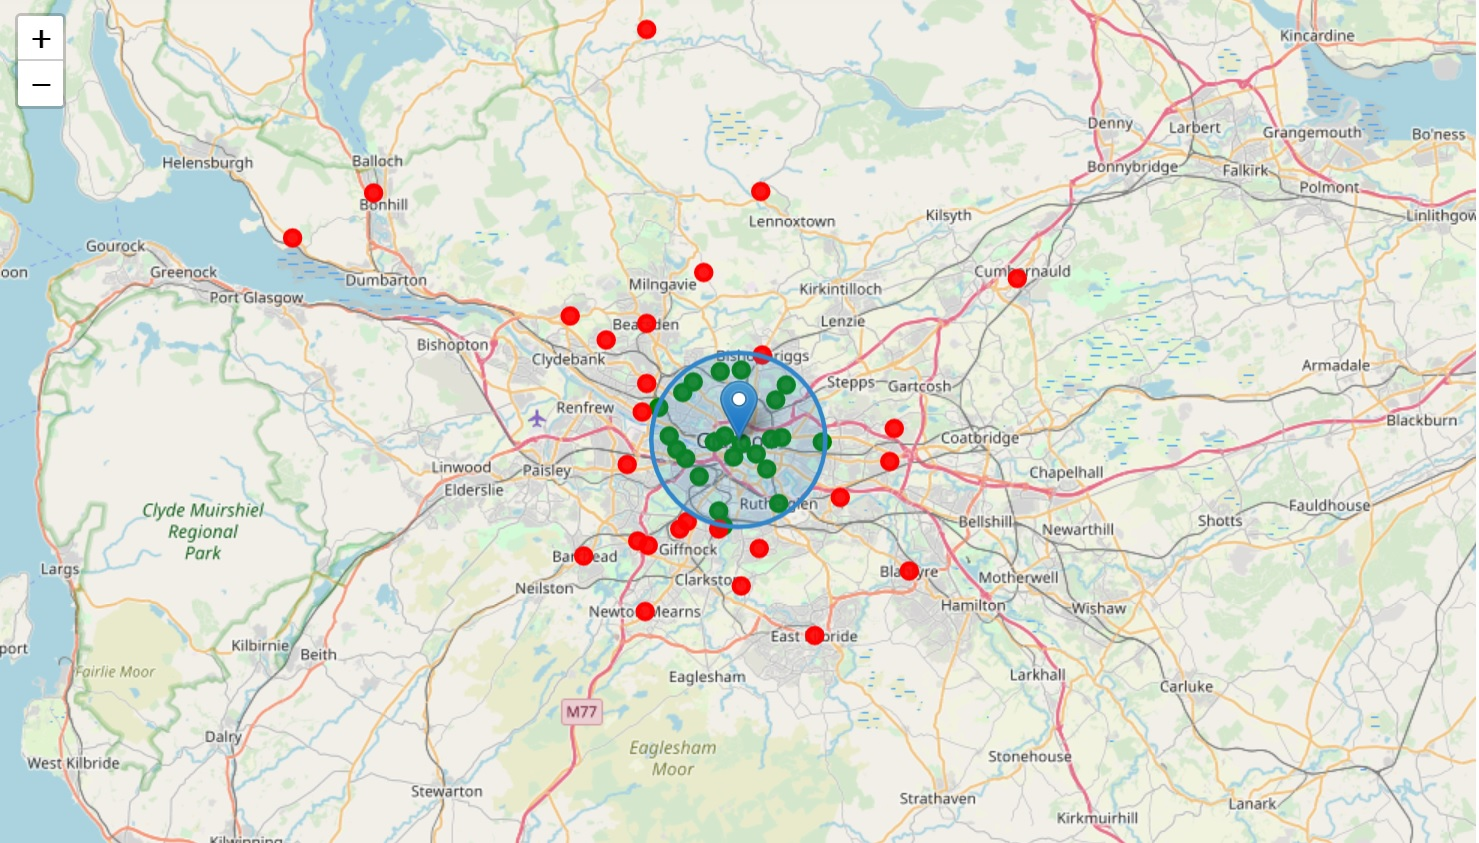

In [23]:
Image("Images/Glasgow_5km.jpg")

Post codes that satisfy the 5 km criteria are shown in green while those that don't satisfy the condition are plotted in red.

### 1.5.3 Performing second stage of data Preprossing to find postal codes with in 5 km of City Center

In [24]:
#Processing the the data set to remove the Postal codes that are more than the required distance away from the city center
Glasgow_dcc=Glasgow[Glasgow['Distance from Center'] <= Distance_from_city_center]
Glasgow_dcc.reset_index(drop=True,inplace = True) 
Glasgow_dcc.head()

Postcode district Post town  \
0                G1   GLASGOW   
1                G2   GLASGOW   
2                G3   GLASGOW   
3                G4   GLASGOW   
4                G5   GLASGOW   

                                            Coverage Local authority area  \
0                                      Merchant City         Glasgow City   
1                  Blythswood Hill, Anderston (part)         Glasgow City   
2  Anderston, Finnieston, Garnethill, Park, Woodl...         Glasgow City   
3  Calton (part), Cowcaddens (part), Drygate, Kel...         Glasgow City   
4                                            Gorbals         Glasgow City   

          District   Latitude  Longitude  Distance from Center  
0    Merchant City  55.859126  -4.246316              0.261226  
1  Blythswood Hill  55.863319  -4.261671              0.839709  
2        Anderston  55.859699  -4.271292              1.406410  
3          Calton   55.853724  -4.232824              1.287026  
4          Gorbals  55.851813  -4.253163              1.054402

In [25]:
Glasgow_dcc=Glasgow_dcc[Glasgow_dcc['Post town']=='GLASGOW']
print('There are',Glasgow_dcc.shape[0],'Postal codes that are within',Distance_from_city_center, 'km from the City Center') 

There are 22 Postal codes that are within 5 km from the City Center


## <span style="color:maroon">1.6 Criteria 2</span>

### 1.6.1 Finding the location of the Subway stations

The data set for the location of the the Subway stations are avaliable at this [link](https://data.glasgow.gov.uk/dataset/glasgow-subway-station-locations/resource/8c057567-55e7-4631-ae77-e37b4a0562e8) from the Glasgow City Council. The dataset is imported. The Nominatim library using foursquare_agent is used to find the coordinates of the Postal codes. These postal codes are manually added to an excel file titled **Subway_Latitude_Longitude** saved Excel_Data folder. This file is imported and merged with the dataset from the glasgow city council.

In [26]:
#The excel file is read and saved in a data frame
Glasgow_df_subway = pd.read_excel('Excel_Data/glasgow_subway_station_locations.xlsx', index_col=0)
print ('Data read into a pandas dataframe!')

Data read into a pandas dataframe!


In [27]:
#The Data is processed to add index values 
Glasgow_df_subway.columns = list(map(str, Glasgow_df_subway.columns))
Glasgow_df_subway.reset_index(level=0, inplace=True)
#Glasgow_df_subway['Postcode'][9]='G51 1NW'
Glasgow_df_subway.head()

Station Name  Address Line 1            Address Line 2 Address Line 3  \
0    Bridge Street              67           Eglinton Street        Glasgow   
1  Buchanan Street             174           Buchanan Street        Glasgow   
2         Cessnock               1           Cessnock Street        Glasgow   
3       Cowcaddens              11  Dundasvale Court, Unit 1        Glasgow   
4            Govan             737                Govan Road        Glasgow   

  Postcode  Easting  Northing Accessible Park and Ride Wi-Fi Bike Shelter  \
0   G5 9NR   258710    664400        Yes           Yes   Yes          Yes   
1   G1 2JZ   259073    665577        Yes            No   Yes           No   
2  G51 1AS   256470    664490        Yes            No   Yes           No   
3   G4 0SN   258679    666191        Yes            No   Yes           No   
4  G51 2YJ   255490    665643        Yes            No   Yes           No   

  Special Car Sharing Parking Spaces Lost Property Number  \
0                                 No       0141 335 3276.   
1                                 No       0141 335 3276.   
2                                 No       0141 335 3276.   
3                                 No       0141 335 3276.   
4                                 No       0141 335 3276.   

                                              Nearby  
0                     Citizen’s Theatre, 02 Academy.  
1  Queen’s Street Station, Buchanan Bus Station, ...  
2                 Glasgow Science Centre, IMAX, SECC  
3        Glasgow School of Art, GFT, Tenement House.  
4  Southern General Hospital, Govan Old Parish Ch...

The following code is used to find the latitude and Longitude of the 15 subway stations:

    from geopy.geocoders import Nominatim
    for n in range (0, Glasgow_df_subway.shape[0]):
        address = '{} {}, {}, Glasgow'.format(Glasgow_df_subway['Address Line 1'][n],Glasgow_df_subway['Address Line 2'][n], Glasgow_df_subway['Postcode'][n])
        geolocator = Nominatim(user_agent="foursquare_agent")
        location = geolocator.geocode(address)
        latitude=location.latitude
        longitude=location.longitude
        print('Index:',n,'{},{} has latitude='.format(Glasgow_df_subway['Station Name'][n], Glasgow_df_subway['Postcode'][n]),latitude,'and longitide=', longitude)

In [28]:
#The excel file is read and saved in a data frame
Glasgow_df_subway_latlog = pd.read_excel('Excel_Data/Subway_Latitude_Longitude.xlsx', index_col=0)
print ('Data read into a pandas dataframe!')

Data read into a pandas dataframe!


In [29]:
Glasgow_df_subway_latlog.columns = list(map(str, Glasgow_df_subway_latlog.columns))
Glasgow_df_subway_latlog.reset_index(level=0, inplace=True)
Glasgow_df_subway_latlog.head()

Station Name   Latitude  Longitude
0    Bridge Street  55.851452  -4.259382
1  Buchanan Street  55.861888  -4.253626
2         Cessnock  55.852726  -4.294110
3       Cowcaddens  55.868063  -4.259899
4            Govan  55.861783  -4.308399

In [30]:
Glasgow_subway = pd.merge(Glasgow_df_subway, Glasgow_df_subway_latlog, on='Station Name')

### 1.6.2 Plotting the Map of the Glasgow Subway 

The folium library is used to plot the positions of the Subway stations in Glasgow.

In [31]:
map_Glasgow_Subway = folium.Map(location=[latitude, longitude],tiles='Stamen Toner', zoom_start=12)
for lat, lng, sname in zip(Glasgow_subway['Latitude'], Glasgow_subway['Longitude'], Glasgow_subway['Station Name']):
    label = 'Station Name: {}'.format(sname)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
    location=[lat, lng],
    radius=Distance_from_Subway_station*1000,
    color='#3186cc',
    stroke= False,
    weight=1,
    fill=True,
    fill_opacity=0.1,
    fill_color='#3186cc'
    ).add_to(map_Glasgow_Subway)
for lat, lng, sname in zip(Glasgow_subway['Latitude'], Glasgow_subway['Longitude'], Glasgow_subway['Station Name']):
    label = 'Station Name: {}'.format(sname)
    label = folium.Popup(label, parse_html=True)
    icon_url='https://upload.wikimedia.org/wikipedia/commons/thumb/c/ca/Glasgow_Subway.svg/800px-Glasgow_Subway.svg.png'
    icon = folium.features.CustomIcon(icon_url,icon_size=(28, 30))
    folium.Marker(
    location=[lat, lng],
    icon=icon,
    popup=label
    ).add_to(map_Glasgow_Subway)

    
map_Glasgow_Subway

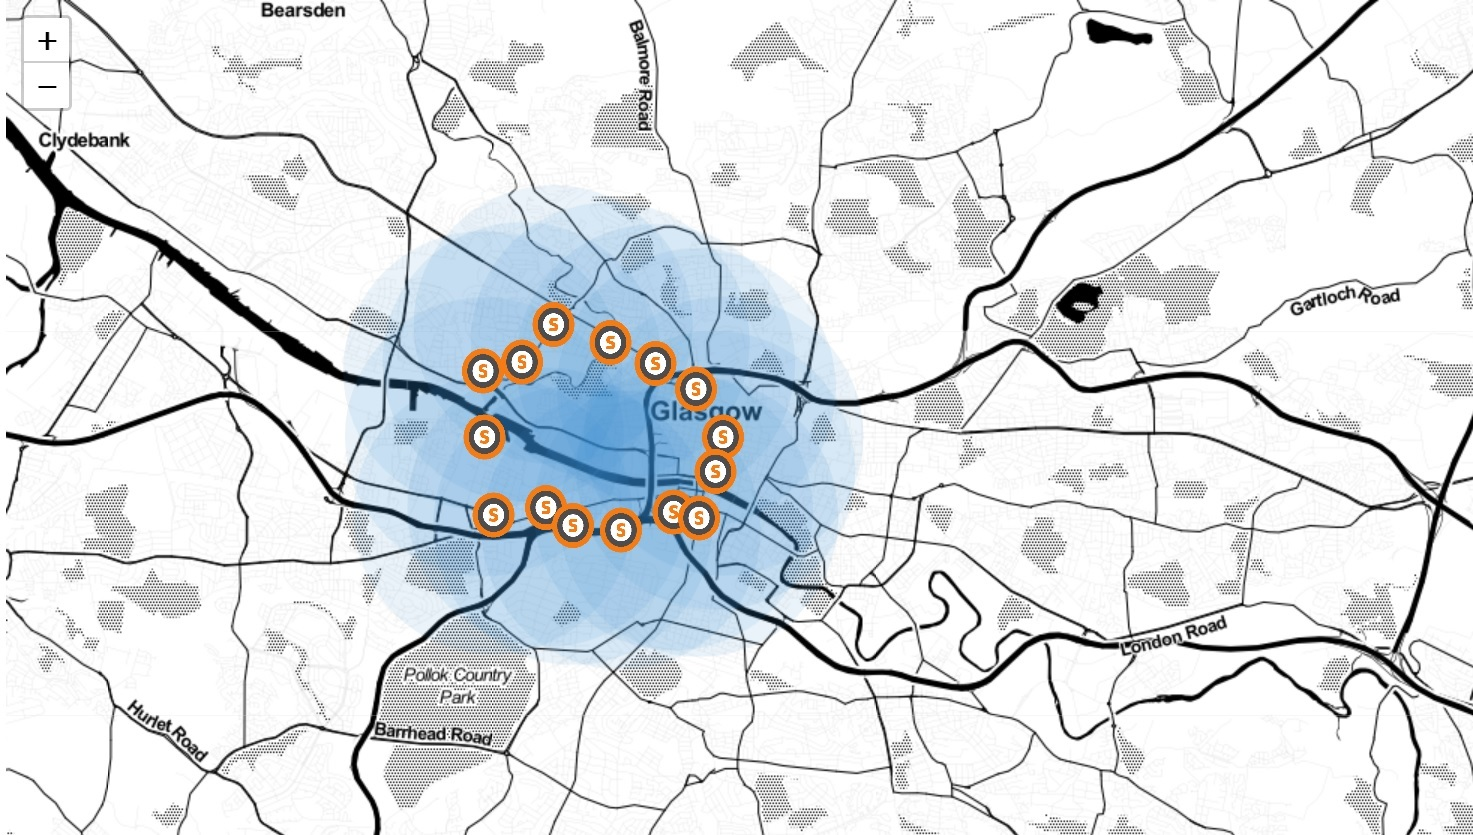

In [32]:
Image("Images/Glasgow_Subway.jpg")

### 1.6.3 Finding the Nearest Subway station and the distance between the postal code and that Subway station

For the 22 Postal codes that are within 5km of the city center, the distance from the nearest subway station is found. For this a function is written that uses the the Haversine Formula to find distance. It returns the name of the nearest subway station and distance to the nearest subway station. Both these paramenters are added to that data frame.  

In [33]:
# Function that returns the distance of the closest subway station and the name of that station
def calculate_distance_from_Subway_station(latitude,longitude):
    Station_names=['Bridge Street', 
                   'Buchanan Street', 
                   'Cessnock', 
                   'Cowcaddens', 
                   'Govan', 
                   'Hillhead', 
                   'Ibrox', 
                   'Kelvinhall', 
                   'Kelvinbridge', 
                   'Kinning Park',
                   'Partick', 
                   'Sheilds Road', 
                   'St. Enoch', 
                   'St Georges Cross', 
                   'West Street']
    distancesarray=np.zeros((len(Station_names)))
    for n in range (len(Station_names)):
        # approximate radius of earth in km
        R = 6373.0
        lat1 = radians(Glasgow_subway['Latitude'][n]) # Latitude Coordinates for the Glasgow City Center
        lon1 = radians(Glasgow_subway['Longitude'][n]) # Longitude Coordinates for the Glasgow City Center
        lat2 = radians(latitude)
        lon2 = radians(longitude)
        #Haversine Formula to find distance
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distancesarray[n] = R * c
        
    min_distance=min(distancesarray)
    index_min=np.argmin(distancesarray)
    station=Station_names[index_min]
    
    return min_distance, station #The distance is returned in km

In [34]:
# Calling the calculate_distance_from_Subway_station function on the postal codes that are within 5 km of 
nearest_station=[]
distancesfromsubway=np.zeros((Glasgow_dcc.shape[0]))
for n in range (Glasgow_dcc.shape[0]):
    lat1=Glasgow_dcc['Latitude'][n]
    long1=Glasgow_dcc['Longitude'][n]
    dist, stat = calculate_distance_from_Subway_station(lat1,long1)
    distancesfromsubway[n]=dist
    nearest_station.append(stat)

In [35]:
Glasgow_dcc['Distance from Nearest Subway']=distancesfromsubway
Glasgow_dcc['Nearest Subway']=nearest_station

In [36]:
Glasgow_dcc.head()

Postcode district Post town  \
0                G1   GLASGOW   
1                G2   GLASGOW   
2                G3   GLASGOW   
3                G4   GLASGOW   
4                G5   GLASGOW   

                                            Coverage Local authority area  \
0                                      Merchant City         Glasgow City   
1                  Blythswood Hill, Anderston (part)         Glasgow City   
2  Anderston, Finnieston, Garnethill, Park, Woodl...         Glasgow City   
3  Calton (part), Cowcaddens (part), Drygate, Kel...         Glasgow City   
4                                            Gorbals         Glasgow City   

          District   Latitude  Longitude  Distance from Center  \
0    Merchant City  55.859126  -4.246316              0.261226   
1  Blythswood Hill  55.863319  -4.261671              0.839709   
2        Anderston  55.859699  -4.271292              1.406410   
3          Calton   55.853724  -4.232824              1.287026   
4          Gorbals  55.851813  -4.253163              1.054402   

   Distance from Nearest Subway   Nearest Subway  
0                      0.550108  Buchanan Street  
1                      0.526778  Buchanan Street  
2                      0.912032      West Street  
3                      1.474669        St. Enoch  
4                      0.390402    Bridge Street

### 1.6.4 Plotting the Postal codes that are with in 2 km of Subway station and 5 km for the city center

Folium library is used to plot the Map. The postal codes that are within 2 km of subway station and 5 km from city center are plotted in green.  

In [37]:
# create map centered around Glasgow
map_Glasgow_Subway_5k = folium.Map(location=[latitude, longitude], zoom_start=11.5)
# Plotting the postal codes, if postal code is within 5 km of city center they are plotted as green circles, 
# if they are not with in 5 km then they are red circles

text = 'City Center of Glasgow'
iframe = folium.IFrame(text, width=200, height=25)
popup = folium.Popup(iframe, max_width=3000)
Text = folium.Marker(location=[55.8609825,-4.2488787], popup=popup)
map_Glasgow_Subway_5k.add_child(Text)

folium.Circle(
    location=[55.8609825,-4.2488787],
    radius=Distance_from_city_center*1000,
    color='#3186cc',
    fill=True,
    stroke= False,
    fill_color='#3186cc',
    fill_opacity=0.4
).add_to(map_Glasgow_Subway_5k)

for lat, lng, sname in zip(Glasgow_subway['Latitude'], Glasgow_subway['Longitude'], Glasgow_subway['Station Name']):
    label = 'Station Name: {}'.format(sname)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
    location=[lat, lng],
    radius=Distance_from_Subway_station*1000,
    color='#3186cc',
    stroke= False,
    weight=1,
    fill=True,
    fill_opacity=0.1,
    fill_color='orange'
    ).add_to(map_Glasgow_Subway_5k)
for lat, lng, sname in zip(Glasgow_subway['Latitude'], Glasgow_subway['Longitude'], Glasgow_subway['Station Name']):
    label = 'Station Name: {}'.format(sname)
    label = folium.Popup(label, parse_html=True)
    icon_url='https://upload.wikimedia.org/wikipedia/commons/thumb/c/ca/Glasgow_Subway.svg/800px-Glasgow_Subway.svg.png'
    icon = folium.features.CustomIcon(icon_url,icon_size=(28, 30))
    folium.Marker(
    location=[lat, lng],
    icon=icon,
    popup=label
    ).add_to(map_Glasgow_Subway_5k)
    
for lat, lng, post, dist in zip(Glasgow_dcc['Latitude'], Glasgow_dcc['Longitude'], Glasgow_dcc['Postcode district'], Glasgow_dcc['Distance from Nearest Subway']):
    label = 'Postal Code: {}'.format(post)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colormapping(dist, Distance_from_Subway_station),
        fill=True,
        fill_color=colormapping(dist, Distance_from_Subway_station),
        fill_opacity=0.9,
        parse_html=False).add_to(map_Glasgow_Subway_5k)  

    
map_Glasgow_Subway_5k

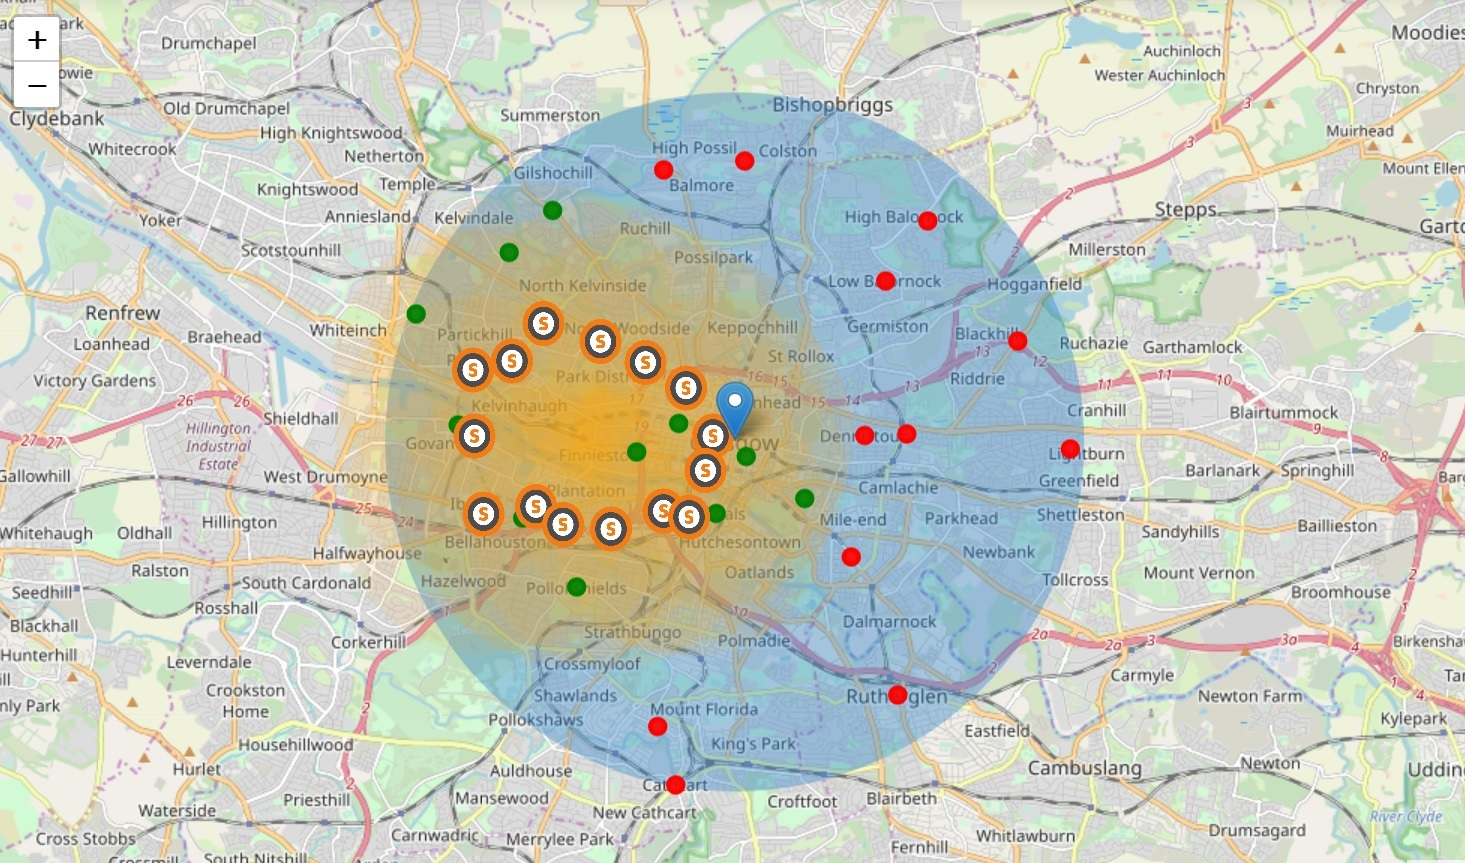

In [38]:
Image("Images/Glasgow_Subway_5k.jpg")

### 1.6.5 Processing the data frame to identity the postal codes that satisfy criteria 1 and 2

In [39]:
#Processing the the data set to remove the Postal codes that are more than the required distance away from the Subway Stations 
Glasgow_dss=Glasgow_dcc[Glasgow_dcc['Distance from Nearest Subway'] <= Distance_from_Subway_station]
Glasgow_dss.reset_index(drop=True,inplace = True) 
Glasgow_dss.head()

Postcode district Post town  \
0                G1   GLASGOW   
1                G2   GLASGOW   
2                G3   GLASGOW   
3                G4   GLASGOW   
4                G5   GLASGOW   

                                            Coverage Local authority area  \
0                                      Merchant City         Glasgow City   
1                  Blythswood Hill, Anderston (part)         Glasgow City   
2  Anderston, Finnieston, Garnethill, Park, Woodl...         Glasgow City   
3  Calton (part), Cowcaddens (part), Drygate, Kel...         Glasgow City   
4                                            Gorbals         Glasgow City   

          District   Latitude  Longitude  Distance from Center  \
0    Merchant City  55.859126  -4.246316              0.261226   
1  Blythswood Hill  55.863319  -4.261671              0.839709   
2        Anderston  55.859699  -4.271292              1.406410   
3          Calton   55.853724  -4.232824              1.287026   
4          Gorbals  55.851813  -4.253163              1.054402   

   Distance from Nearest Subway   Nearest Subway  
0                      0.550108  Buchanan Street  
1                      0.526778  Buchanan Street  
2                      0.912032      West Street  
3                      1.474669        St. Enoch  
4                      0.390402    Bridge Street

In [40]:
print('There are',Glasgow_dss.shape[0],'Postal codes that are within',Distance_from_city_center, 'km from the City Center and that are within', Distance_from_Subway_station,'km from the subway stations') 

There are 10 Postal codes that are within 5 km from the City Center and that are within 2 km from the subway stations


## <span style="color:maroon">1.7 Criteria 3 and 4</span>

To analyze the Population and the Population Diversity of each Postal Code two data set are used.

1) [Royal Mail Data set:](http://www.glasgow.gov.uk/CHttpHandler.ashx?id=16002&p=0) This data set contains all the postal codes in Glasgow. It has almost 15,000 data entries. Along with the Postal codes it also has the corresponding Datazone

2) [Glasgow City Council Data Set:](https://data.glasgow.gov.uk/dataset/national-identity-by-ethnic-group-2011-census) This data set contains the Datazone entries along with the national Identity of the population in that Data Zone. The data set has almost 6200 entries.

Both these data sets are imported and processed to extract the population at each postcode. The ethnicity of the population is also extracted. 

### 1.7.1 Data Preprocessing of the Glasgow City council Data Set

The Glasgow City Council data set is imported and processed.

In [41]:
Glasgow_ethnicity = pd.read_excel('Excel_Data/nationalidentitybyethnicgroup_2.xlsx', index_col=0)
print ('Data read into a pandas dataframe!')

Data read into a pandas dataframe!


In [42]:
Glasgow_ethnicity.columns = list(map(str, Glasgow_ethnicity.columns))
Glasgow_ethnicity.reset_index(level=0, inplace=True)
Glasgow_ethnicity.head()

Data Zone Intermediate Geography Name  \
0  S01003025            Carmunnock South   
1  S01003025            Carmunnock South   
2  S01003025            Carmunnock South   
3  S01003025            Carmunnock South   
4  S01003025            Carmunnock South   

                              Sub group  All people  White: Total  \
0                            All people         857           833   
1                Scottish identity only         517           508   
2                 British identity only          89            80   
3  Scottish and British identities only         193           191   
4     Scottish and any other identities          15            14   

   White: Scottish  White: Other British  White: Irish  White: Other (1)  \
0              741                    50            20                22   
1              482                     7            12                 7   
2               57                    20             1                 2   
3              189                     0             1                 1   
4                8                     4             0                 2   

   Mixed or multiple ethnic groups  Asian Asian Scottish or Asian British  \
0                                1                                     20   
1                                1                                      8   
2                                0                                      9   
3                                0                                      2   
4                                0                                      1   

   African  Caribbean or Black  Other ethnic groups  
0        0                   1                    2  
1        0                   0                    0  
2        0                   0                    0  
3        0                   0                    0  
4        0                   0                    0

In [43]:
Glasgow_ethnicity.shape

(6210, 14)

In [44]:
Glasgow_ethnicity_df=Glasgow_ethnicity[Glasgow_ethnicity['Sub group'] == 'All people']
Glasgow_ethnicity_df.reset_index(drop=True,inplace = True) 

In [45]:
Glasgow_ethnicity_df=Glasgow_ethnicity_df[['Data Zone', 'All people', 'White: Total', 'Asian Asian Scottish or Asian British', 'African']]

In [46]:
Glasgow_ethnicity_df.shape

(690, 5)

### 1.7.2 Preprocessin the Royal Mail Data Set

In [47]:
Glasgow_Royalmail = pd.read_excel('Excel_Data/RoyalMailPostalCodes.xlsx', index_col=0)
print ('Data read into a pandas dataframe!')

Data read into a pandas dataframe!


In [48]:
Glasgow_Royalmail.columns = list(map(str, Glasgow_Royalmail.columns))
Glasgow_Royalmail.reset_index(level=0, inplace=True)
Glasgow_Royalmail.head()

Postcode unit Type of Postcode Sector Community Planning Partnership   \
0        G1 1BL       small user                             North West   
1        G1 1BQ       small user                             North West   
2        G1 1BX       Large User                             North West   
3        G1 1DA       small user                             North West   
4        G1 1DG       small user                             North West   

  Multi member Ward / Local Area Partnership  Data Zone  \
0                             Anderston/City  S01003366   
1                             Anderston/City  S01003358   
2                             Anderston/City  S01003399   
3                             Anderston/City  S01003358   
4                             Anderston/City  S01003358   

   Data Zone Rank (SIMD 2012) Is this in a bottom 15% Data Zone?  
0                        4833                                 no  
1                        1847                                 no  
2                        4029                                 no  
3                        1847                                 no  
4                        1847                                 no

Creating a variable that is used to store the postal codes that were shortlisted in the Previous Data Analysis

In [49]:
strings=['G1 ', 'G2 ', 'G3 ', 'G4 ', 'G5 ', 'G11 ', 'G12 ', 'G20 ', 'G41 ', 'G51 ']

Declaring the Data frame that will be used to store the Data for population in the postal codes

In [50]:
summary = pd.DataFrame(columns=['Data Zone','All people','White: Total','Asian Asian Scottish or Asian British','African','Post Code'])

In [51]:
for b in range (len(strings)):
    mask = np.column_stack([Glasgow_Royalmail['Postcode unit'].str.contains(strings[b], na=False) for col in Glasgow_Royalmail])
    G=Glasgow_Royalmail.loc[mask.any(axis=1)]
    Data_zones=G['Data Zone'].unique()
    for n in range (len(Data_zones)):
        u1=Glasgow_ethnicity_df[Glasgow_ethnicity_df['Data Zone'] == Data_zones[n]]
        u1['Post Code']=strings[b]
        summary=summary.append(u1, ignore_index = True)

C:\Users\rabiy\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [52]:
summary.shape

(244, 6)

In [53]:
summary2 = pd.DataFrame(columns=['All people','White','White Percentage','Asian','Asian Percentage','African','African Percentage','Post Code'])

In [54]:
for n in range (len(strings)):
    new=summary[summary['Post Code']== strings[n]]
    population=new.sum()[1]
    White=new.sum()[2]
    White_percent=(White/population)*100
    Asian=new.sum()[3]
    Asian_percent=(Asian/population)*100
    African=new.sum()[4]
    African_percent=(African/population)*100
    toadd = pd.DataFrame({"All people":[population], 
                    "White":[White],
                    'White Percentage':[White_percent],
                    'Asian':[Asian],
                    'Asian Percentage':[Asian_percent],
                    'African':[African],
                    'African Percentage':[African_percent],
                    'Post Code':[strings[n]]
                   }) 
    summary2=summary2.append(toadd, ignore_index = True)

In [55]:
summary2.sort_values(['All people'], ascending=False, axis=0, inplace=True)
summary2.reset_index(drop=True,inplace = True) 

In [56]:
summary2['Other']=summary2['All people']-(summary2['Asian']+summary2['White']+summary2['African'])
summary2['Other Percentage']=100-(summary2['White Percentage']+summary2['Asian Percentage']+summary2['African Percentage'])

In [57]:
summary2

All people  White  White Percentage Asian  Asian Percentage African  \
0      36994  26830         72.525274  8792         23.766016     639   
1      36269  31681         87.350079  2866          7.902065    1028   
2      31367  27572         87.901298  2814          8.971212     249   
3      26862  20312         75.616112  5083         18.922642     478   
4      24474  18245         74.548500  4353         17.786222    1008   
5      24405  20653         84.626101  2641         10.821553     740   
6      23157  20916         90.322581  1598          6.900721     169   
7      13291  10450         78.624633  2084         15.679783     306   
8      11781   9669         82.072829  1283         10.890417     611   
9       9736   7578         77.834840  1565         16.074363     218   

   African Percentage Post Code Other  Other Percentage  
0            1.727307      G41    733          1.981402  
1            2.834376      G20    694          1.913480  
2            0.793828      G12    732          2.333663  
3            1.779465       G3    989          3.681781  
4            4.118657       G4    868          3.546621  
5            3.032166      G51    371          1.520180  
6            0.729801      G11    474          2.046897  
7            2.302310       G1    451          3.393274  
8            5.186317       G5    218          1.850437  
9            2.239113       G2    375          3.851684

The 10 Postal codes that have been shortlisted so far are listed in the data frame above. In order to shortlist these postal codes further on the bases of population, the total population and ethnicity data is plotted for better visualization. The aim is to select three final postcodes to search for potential venues using the FoursquareAPI. Postal code with a larger population are prefered. **But selection priority is given to postal codes having higher diversity of population over total population.**

### 1.7.3 Plotting the Total population at each postal code

In [58]:
# Importing libraries for plotting
from PIL import Image # converting images into arrays
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.1.1


In the first plot, The total population is plotted. The postal codes are arranged in desending order of population. The postal codes having the six largest populations are G41, G20, G12, G3, G4 and G11 (arranged according to population)

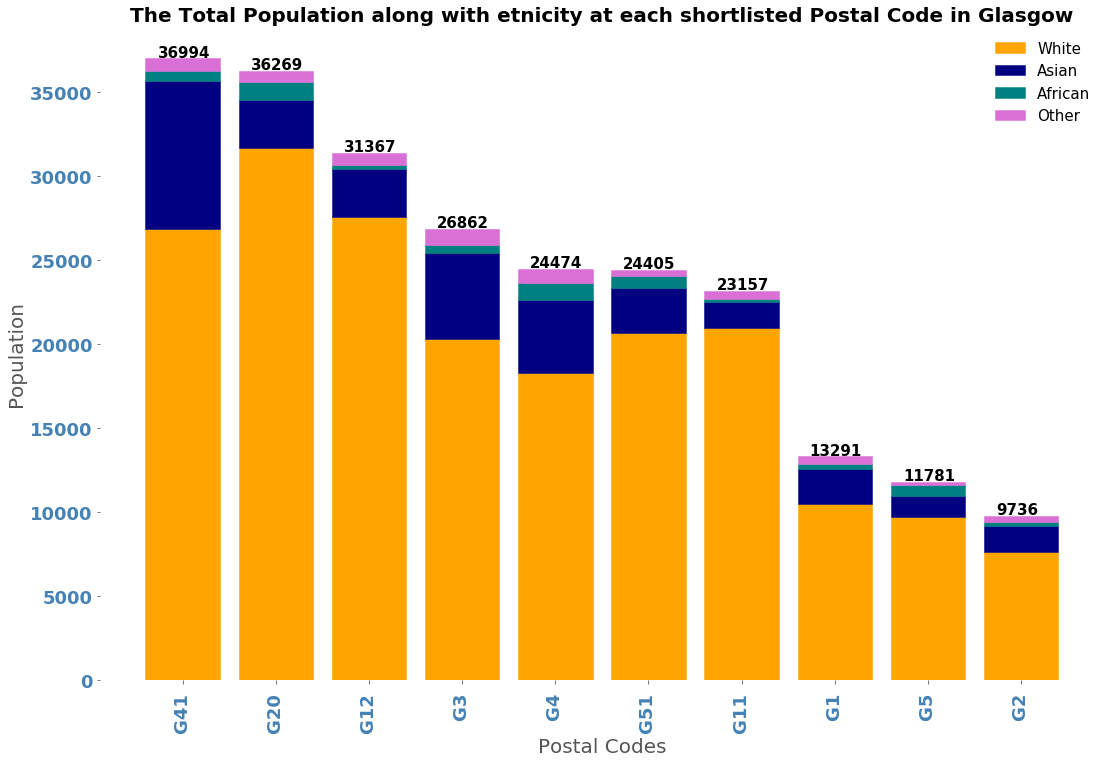

In [59]:
f, ax = plt.subplots(figsize=(18, 12))
plt.xticks(fontsize=18, rotation=90, color='steelblue', fontweight='bold')
plt.yticks(fontsize=18, rotation=0, color='steelblue', fontweight='bold')
ax.set_facecolor("white")

#sns.barplot(x="Post Code", y='All people', data=summary2, color="m")
plt.bar(summary2['Post Code'], summary2['White'], color='orange', edgecolor='orange', label="White")
plt.bar(summary2['Post Code'], summary2['Asian'], bottom=summary2['White'], color='navy', edgecolor='navy', label="Asian")
plt.bar(summary2['Post Code'], summary2['African'], bottom=summary2['White']+summary2['Asian'], color='teal', edgecolor='teal', label='African')
plt.bar(summary2['Post Code'], (summary2['All people']-(summary2['White']+summary2['Asian']+summary2['African'])), bottom=summary2['White']+summary2['Asian']+summary2['African'], color='orchid', edgecolor='orchid', label='Other')

ax.set_xlabel('Postal Codes', fontsize=20)
ax.set_ylabel("Population", fontsize=20)
ax.set_title('The Total Population along with etnicity at each shortlisted Postal Code in Glasgow', fontsize=20, fontweight='bold')
ax.legend(loc="upper right", frameon=False, fontsize=15, facecolor="white")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines['bottom'].set_visible(False)

for i, label in enumerate(list(summary2['All people'].index)):
    score = summary2.loc[label]['All people']
    ax.annotate((str(round(score,2))), (i-0.27, score+100), size=15, color='k', weight='bold')

In order to further analyse the top 6 post codes <span style="color:red">**(G41, G20, G12, G3, G4 and G11)**</span>, The percentage of the top three ethnicities in the postal districts are plotted.  

### 1.7.4 Plotting the percentage of the top three ethnicities

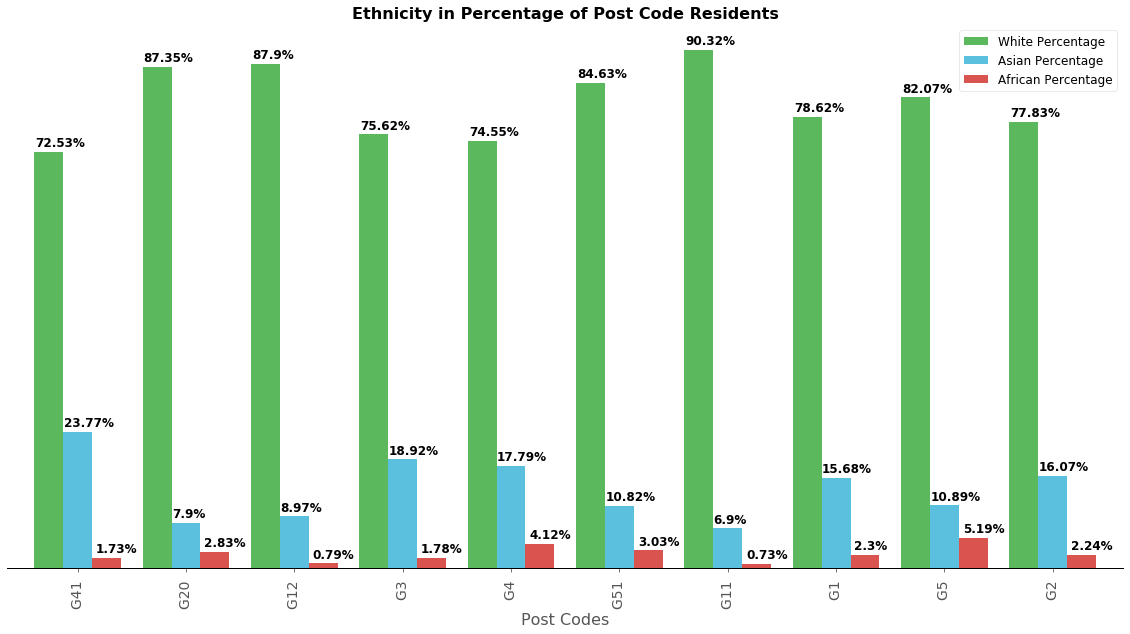

In [60]:
subset=summary2[['Post Code','White Percentage', 'Asian Percentage','African Percentage']]
subset=subset[0:11]
subset=subset.set_index('Post Code')

mpl.rc('axes',edgecolor='black')
ax=subset.plot(kind='bar', figsize=(20, 10), color=['#5cb85c', '#5bc0de', '#d9534f'], width=0.8, fontsize=14)
ax.spines["right"].set_visible(False)

ax.set_title('Ethnicity in Percentage of Post Code Residents', fontsize=16, loc='center', fontweight='bold')
ax.set_xlabel('Post Codes', fontsize=16)

ax.legend(fontsize=12, shadow=False, facecolor="white", loc='upper right', ncol=1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines['bottom'].set_linewidth(1)
ax.axes.get_yaxis().set_ticks([])
ax.set_facecolor("white")

for i, label in enumerate(list(subset['White Percentage'].index)):
    score = subset.loc[label]['White Percentage']
    ax.annotate((str(round(score,2))+str('%')), (i-0.39, score+1), size=12, rotation=0, fontweight='bold')

for i, label in enumerate(list(subset['Asian Percentage'].index)):
    score = subset.loc[label]['Asian Percentage']
    ax.annotate((str(round(score,2))+str('%')), (i-0.13, score+1),size=12, rotation=0, fontweight='bold')
    
for i, label in enumerate(list(subset['African Percentage'].index)):
    score = subset.loc[label]['African Percentage']
    ax.annotate((str(round(score,2))+str('%')), (i+0.17, score+1), size=12, rotation=0, fontweight='bold')

The postal codes can be clustered into possible sub groups based on similarity of population profile. 

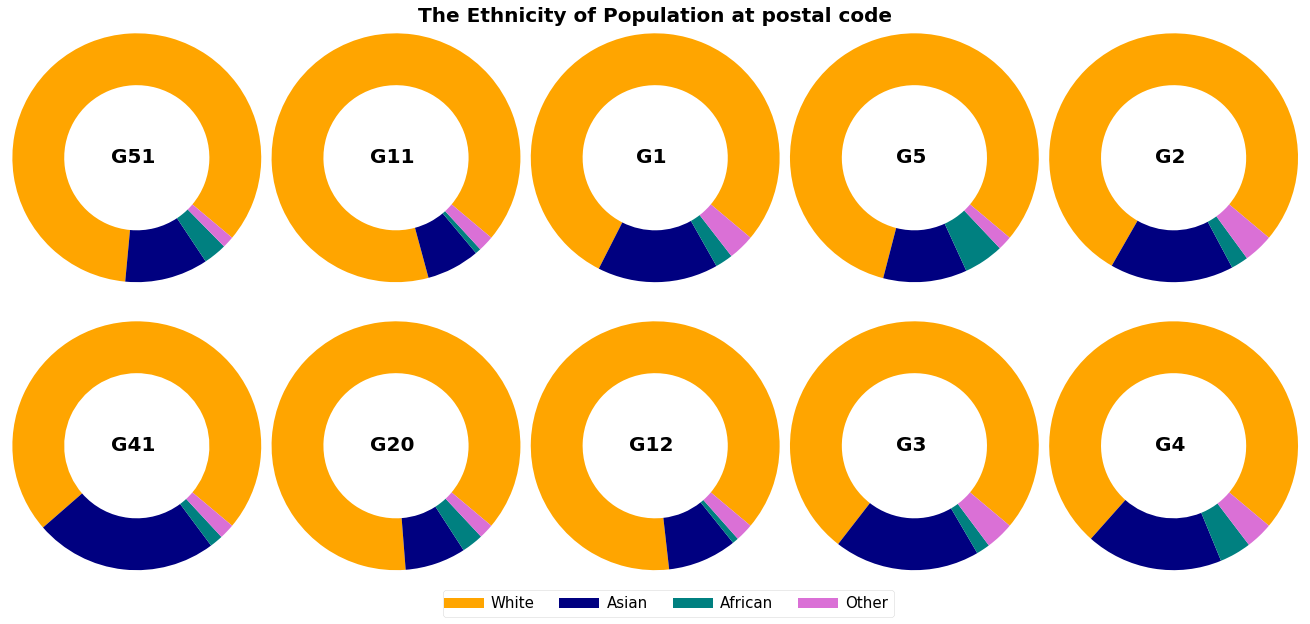

In [108]:
#Plotting Donut Plots
cols = ['orange', 'navy', 'teal', 'orchid']

fig = plt.figure(figsize=(18, 20))
labels = ['White', 'Asian', 'African', 'Other']

pos1=[0, 0.2, 0.4, 0.6, 0.8, 0,0.2,0.4,0.6,0.8]
pos2=[0,0,0,0,0,0.2, 0.2, 0.2, 0.2, 0.2]

for n in range (len(pos1)):
    data1 = [summary2['White'][n], summary2['Asian'][n], summary2['African'][n], (summary2['All people'][n]-(summary2['White'][n]+summary2['Asian'][n]+summary2['African'][n]))]
    ax = fig.add_axes([pos1[n], pos2[n], .2, .2], aspect=1)
    ax.pie(data1, wedgeprops=dict(width=0.5), radius = 1.2, startangle=-40, colors=cols)
    kwargs = dict(size=20, fontweight='bold', va='center')
    ax.text(0, 0, summary2['Post Code'][n], ha='center', **kwargs)
    if n==7:
        ax.set_title('The Ethnicity of Population at postal code',fontweight='bold', fontsize=20)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='orange', lw=10),
                Line2D([0], [0], color='navy', lw=10),
                Line2D([0], [0], color='teal', lw=10),
                Line2D([0], [0], color='orchid', lw=10)]

ax.legend(custom_lines, ['White', 'Asian', 'African', 'Other'], ncol=4, facecolor="white", loc='lower center', bbox_to_anchor=(-1.7, -1.3, 0.5, 0.5), fontsize=15)
plt.show()

As can be seen from the donut plots. Some post codes have similar population diversity like G12 and G11. This similarity maybe due to the geographical proximity of the postal codes to each other. Similarly, G2 and G3 have similar population diversity as well. In order to better cluster that postal codes, k-means algorithm will be used to cluster the neigborhood based on the population data along with the most popular venues within these postal codes.   

In [314]:
#Preprocessing the Data to draw map

subset=summary2[0:6]
subset.columns = list(map(str, subset.columns))
strings2=['G41', 'G20', 'G12', 'G3', 'G4', 'G11']
subset['Post Code']=strings2
Top6= pd.merge(Glasgow_dss, subset, on='Post Code')
set1=['G41', 'G3', 'G4']
set2=['G20', 'G12', 'G11']
Subset1=Top6.loc[Top6['Post Code'].isin(set1)]
Subset2=Top6.loc[Top6['Post Code'].isin(set2)]

C:\Users\rabiy\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
Glasgow_dss=Glasgow_dss.rename(columns={"Postcode district": "Post Code"})
Top6= pd.merge(Glasgow_dss, subset, on='Post Code')

In [316]:
# create map centered around Glasgow
map_Glasgow_Subway_5k_Top6 = folium.Map(location=[latitude, longitude], zoom_start=11.5)
# Plotting the postal codes, if postal code is within 5 km of city center they are plotted as green circles, 
# if they are not with in 5 km then they are red circles


folium.Circle(
    location=[55.8507965,-4.2564398],
    radius=2400,
    color='tomato',
    fill=True,
    stroke= False,
    fill_color='tomato',
    fill_opacity=0.2
).add_to(map_Glasgow_Subway_5k_Top6)

folium.Circle(
    location=[55.8854112,-4.3004182],
    radius=2000,
    color='magenta',
    fill=True,
    stroke= False,
    fill_color='magenta',
    fill_opacity=0.2
).add_to(map_Glasgow_Subway_5k_Top6)


for lat, lng, post in zip(Subset1['Latitude'], Subset1['Longitude'], Subset1['Post Code']):
    label = 'Postal Code: {}'.format(post)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.9,
        parse_html=False).add_to(map_Glasgow_Subway_5k_Top6)  

for lat, lng, post in zip(Subset2['Latitude'], Subset2['Longitude'], Subset2['Post Code']):
    label = 'Postal Code: {}'.format(post)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.9,
        parse_html=False).add_to(map_Glasgow_Subway_5k_Top6) 
    
map_Glasgow_Subway_5k_Top6

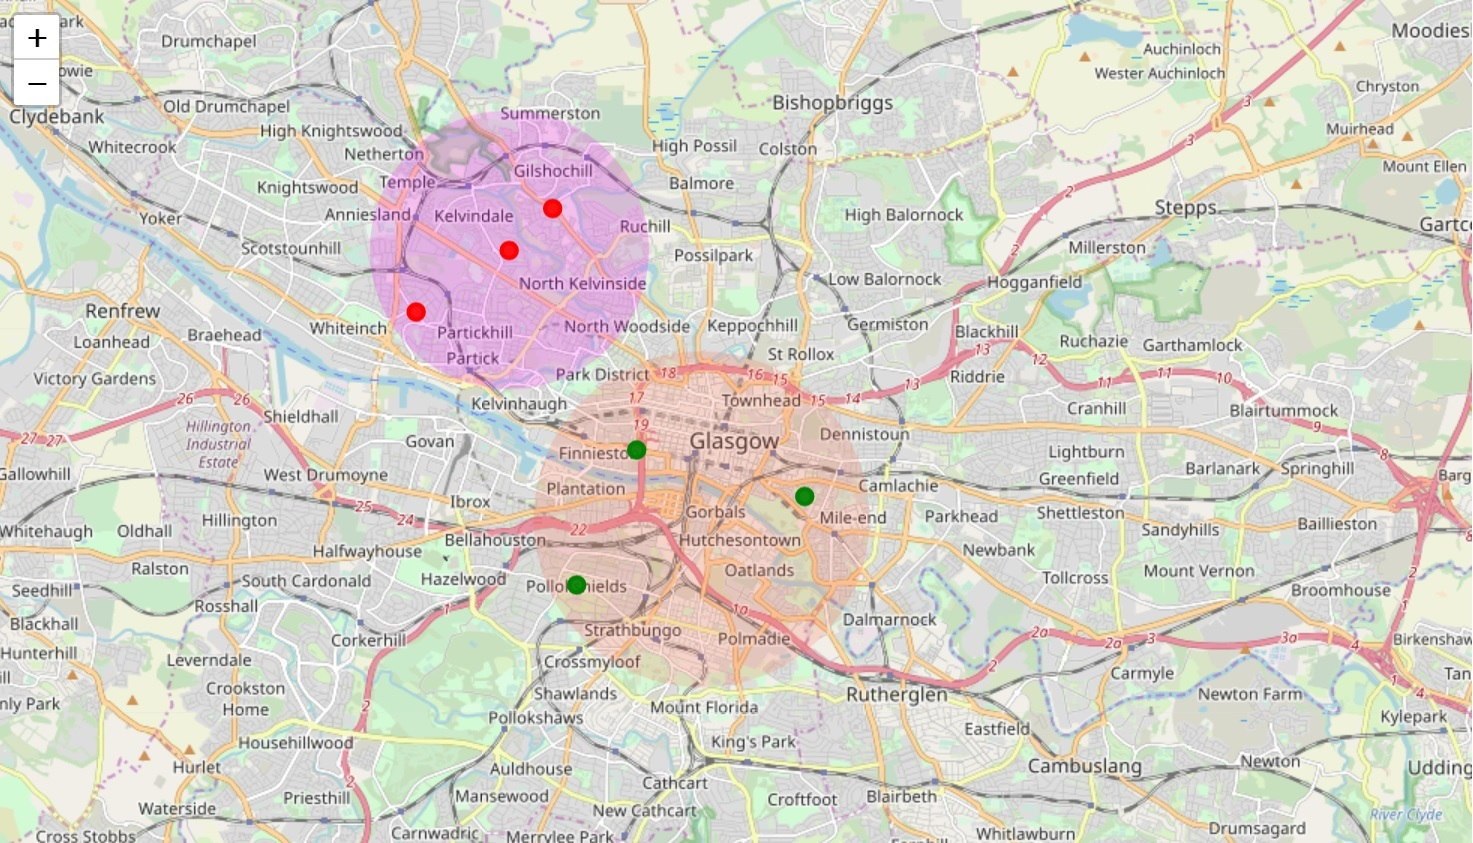

In [317]:
from IPython.display import Image
Image("Images/Glasgow_12.jpg")

The postal codes shown above are selected for further analysis. 

**Summary of final selection of Post codes**  
-  G41    
-  G3    
-  G4

These post codes meet the four criteria identified at the begining of the search. 

1. They are within 5 km of the City Center
2. They are within 2 km of the subway are easily accessable address.
3. They have high population
4. They have a diverse population

The postal codes were narrowed down from an initial list of 56 options to 3. This concludes the first stage of the project. Further analysis of these postal codes is performed using the FoursquaresAPI. 

----

# Stage 2
---

The area of search around the three postcode centers are defined in such a way as to not have any overlapping area. This is done so as to avoid duplication of results in the return query from the FoursquareAPI. Summary of the radius of Interest is given in the table below.   

Postal Code | Latitude | Longitude | Radius of Interest around Postal Code (meters)
--- | --- | --- | ---
G41 | 55.842266 | -4.284997 | 1000 
G3 | 55.859699 | -4.271292 | 1400 
G4 | 55.853724 | -4.232824 | 1000

Using these radius mearsurement avoids overlapping area as can be seen in the map below. 

**Note:** Other postal codes border the three shortlisted postal codes. The search area defined is very large. So, when these radius are specified as a parameter of search in the Foursquare API, it might result in returning venues that belong to the neigboring postal codes as well.

In [66]:
# create map centered around Glasgow
map_Glasgow_Subway_5k_Top3 = folium.Map(location=[55.8507965,-4.2564398], zoom_start=11)

folium.Circle(
    location=[55.8507965,-4.2564398],
    radius=2400,
    color='tomato',
    fill=True,
    stroke= False,
    fill_color='tomato',
    fill_opacity=0.2
).add_to(map_Glasgow_Subway_5k_Top6)

count=0
radiusdef=[1000, 1400, 1000]

for lat, lng, post in zip(Subset1['Latitude'], Subset1['Longitude'], Subset1['Post Code']):
    label = 'Postal Code: {}'.format(post)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
    location=[lat,lng],
    radius=radiusdef[count],
    color='yellow',
    fill=True,
    stroke= False,
    fill_color='mediumvioletred',
    fill_opacity=0.25
    ).add_to(map_Glasgow_Subway_5k_Top3)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.9,
        parse_html=False).add_to(map_Glasgow_Subway_5k_Top3)
    count=count+1

radiusdef=[1200, 600, 600]
count=0
for lat, lng, post in zip(Subset2['Latitude'], Subset2['Longitude'], Subset2['Post Code']):
    label = 'Postal Code: {}'.format(post)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
    location=[lat,lng],
    radius=radiusdef[count],
    color='yellow',
    fill=True,
    stroke= False,
    fill_color='mediumvioletred',
    fill_opacity=0.25
    ).add_to(map_Glasgow_Subway_5k_Top3)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.9,
        parse_html=False).add_to(map_Glasgow_Subway_5k_Top3)
    count=count+1

map_Glasgow_Subway_5k_Top3

In [154]:
# create map centered around Glasgow
map_Glasgow_Subway_5k_Top3 = folium.Map(location=[55.8507965,-4.2564398], zoom_start=12.5)

folium.Circle(
    location=[55.8507965,-4.2564398],
    radius=2400,
    color='tomato',
    fill=True,
    stroke= False,
    fill_color='tomato',
    fill_opacity=0.2
).add_to(map_Glasgow_Subway_5k_Top6)

count=0
radiusdef=[1000, 1400, 1000]

for lat, lng, post in zip(Subset1['Latitude'], Subset1['Longitude'], Subset1['Post Code']):
    label = 'Postal Code: {}'.format(post)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
    location=[lat,lng],
    radius=radiusdef[count],
    color='yellow',
    fill=True,
    stroke= False,
    fill_color='mediumvioletred',
    fill_opacity=0.25
    ).add_to(map_Glasgow_Subway_5k_Top3)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.9,
        parse_html=False).add_to(map_Glasgow_Subway_5k_Top3)
    count=count+1

map_Glasgow_Subway_5k_Top3

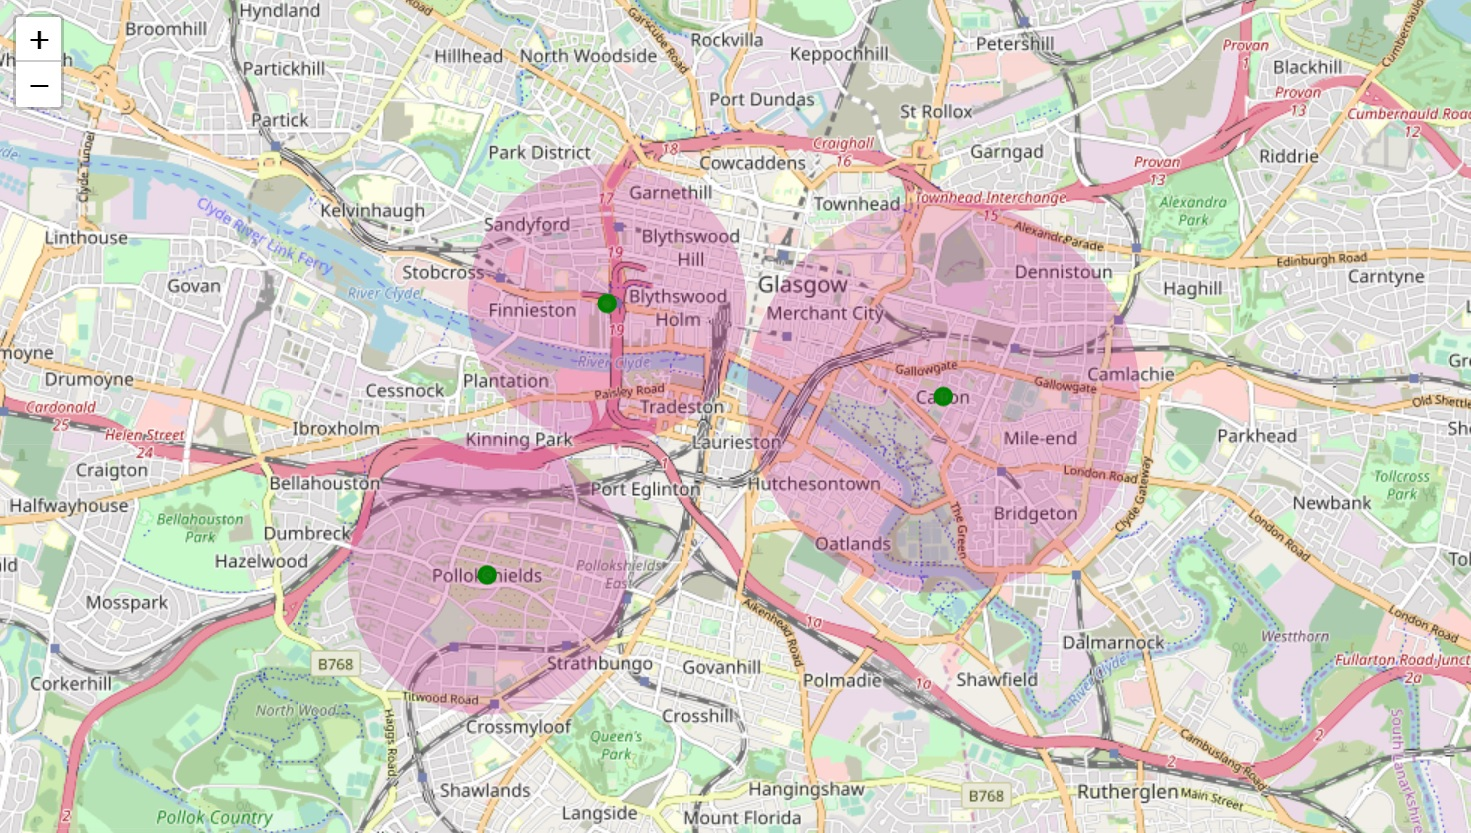

In [155]:
Image("Images/top3_radius.jpg")

### Using the FourSquareAPI

In [88]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Solving environment: ...working... 
  - anaconda/win-64::ca-certificates-2019.8.28-0, anaconda/win-64::certifi-2019.9.11-py37_0, anaconda/win-64::conda-4.8.1-py37_0, anaconda/win-64::openssl-1.1.1d-he774522_2
  - anaconda/win-64::ca-certificates-2019.8.28-0, anaconda/win-64::certifi-2019.9.11-py37_0, anaconda/win-64::openssl-1.1.1d-he774522_2, defaults/win-64::conda-4.8.1-py37_0
  - anaconda/win-64::certifi-2019.9.11-py37_0, anaconda/win-64::conda-4.8.1-py37_0, anaconda/win-64::openssl-1.1.1d-he774522_2, defaults/win-64::ca-certificates-2019.8.28-0
  - anaconda/win-64::certifi-2019.9.11-py37_0, anaconda/win-64::openssl-1.1.1d-he774522_2, defaults/win-64::ca-certificates-2019.8.28-0, defaults/win-64::conda-4.8.1-py37_0
  - anaconda/win-64::conda-4.8.1-py37_0, anaconda/win-64::openssl-1.1.1d-he774522_2, defaults/win-64::ca-certificates-2019.8.28-0, defaults/win-64::certifi-2019.9.11-py37_0
  - anaconda/win-64::openssl-1.1.1d-he774522_2, defaults/win-64::ca-certificates-2019.8.28-0, defau

In [89]:
CLIENT_ID = 'QLWBFES2PFMPR1IVSL41IJ5ID3P34X5RKEVCZ4VOVZVTL2XR' # your Foursquare ID
CLIENT_SECRET = 'UOQMJWU4JSHHHKVBCXAFB2X5VBVRSFKCHKSSLUZHISU0LFFZ' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QLWBFES2PFMPR1IVSL41IJ5ID3P34X5RKEVCZ4VOVZVTL2XR
CLIENT_SECRET:UOQMJWU4JSHHHKVBCXAFB2X5VBVRSFKCHKSSLUZHISU0LFFZ


In [90]:
G3_latitude=55.859699
G3_Longitude= -4.271292
G3_Radius= 1400
G4_latitude=55.853724
G4_Longitude= -4.232824
G4_Radius= 1000
G41_latitude=55.842266
G41_Longitude= -4.284997
G41_Radius= 1000

### Finding the nearest 100 venues to G3

In [91]:
latitude= G3_latitude
longitude= G3_Longitude
radius= G3_Radius
LIMIT=100
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
import requests
results = requests.get(url).json()
'There are {} venues around G3'.format(len(results['response']['groups'][0]['items']))
items = results['response']['groups'][0]['items']
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

dataframe = json_normalize(items) # flatten JSON
# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered = dataframe.loc[:, filtered_columns]
# filter the category for each row
dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)
# clean columns
dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]
dataframe_filtered.head()
# DF TO EXCEL
from pandas import ExcelWriter
G3 =dataframe_filtered
writer = ExcelWriter('G3_venues.xlsx')
G3.to_excel(writer,'Sheet1')
writer.save()

In [92]:
G3.shape

(100, 16)

In [93]:
Post=G3['postalCode']
postupper=Post.str.upper()
G3['postalCode']=postupper
G3=G3.dropna(subset=['postalCode'])
G3['Post']= G3['postalCode'].str.rsplit(" ", n =0 , expand = False).str[0]

C:\Users\rabiy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [94]:
G3['Post'].value_counts()

G2    46
G3    28
G1    21
G5     2
Name: Post, dtype: int64

### Finding the nearest 100 venues to G4

In [95]:
latitude= G4_latitude
longitude= G4_Longitude
radius= G4_Radius
LIMIT=100
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
import requests
results = requests.get(url).json()
'There are {} venues around G4'.format(len(results['response']['groups'][0]['items']))
items = results['response']['groups'][0]['items']
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

dataframe = json_normalize(items) # flatten JSON
# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered = dataframe.loc[:, filtered_columns]
# filter the category for each row
dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)
# clean columns
dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]
dataframe_filtered.head()
# DF TO EXCEL
from pandas import ExcelWriter
G4 =dataframe_filtered
writer = ExcelWriter('G4_venues.xlsx')
G4.to_excel(writer,'Sheet1')
writer.save()

In [96]:
G4.shape

(53, 16)

In [97]:
Post=G4['postalCode']
postupper=Post.str.upper()
G4['postalCode']=postupper
G4=G4.dropna(subset=['postalCode'])
G4['Post']= G4['postalCode'].str.rsplit(" ", n =0 , expand = False).str[0]

C:\Users\rabiy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [98]:
G4['Post'].value_counts()

G1     24
G40     9
G4      7
G31     6
G5      1
Name: Post, dtype: int64

### Finding the nearest 100 venues to G41

In [99]:
latitude= G41_latitude
longitude= G41_Longitude
radius= G41_Radius
LIMIT=100
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
import requests
results = requests.get(url).json()
'There are {} venues around G3'.format(len(results['response']['groups'][0]['items']))
items = results['response']['groups'][0]['items']
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

dataframe = json_normalize(items) # flatten JSON
# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered = dataframe.loc[:, filtered_columns]
# filter the category for each row
dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)
# clean columns
dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]
dataframe_filtered.head()
# DF TO EXCEL
from pandas import ExcelWriter
G41 =dataframe_filtered
writer = ExcelWriter('G41_venues.xlsx')
G41.to_excel(writer,'Sheet1')
writer.save()

In [100]:
G41.shape

(16, 15)

In [101]:
Post=G41['postalCode']
postupper=Post.str.upper()
G41['postalCode']=postupper
G41=G41.dropna(subset=['postalCode'])
G41['Post']= G41['postalCode'].str.rsplit(" ", n =0 , expand = False).str[0]

C:\Users\rabiy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [102]:
G41['Post'].value_counts()

G41    10
Name: Post, dtype: int64

In [103]:
G4

name           categories  \
0            WEST Brewery, Bar & Restaurant              Brewery   
1                              Saint Luke’s          Music Venue   
2                       Barrowland Ballroom          Music Venue   
3                             Glasgow Green                 Park   
4                           People's Palace       History Museum   
5                                   Drygate              Brewery   
6                                 Redmond's                  Pub   
7                          Merchant Chippie    Fish & Chips Shop   
8                             Café Gandolfi  Scottish Restaurant   
9                                 Morrisons          Supermarket   
10                             McCune Smith        Deli / Bodega   
11                                   Dhabba    Indian Restaurant   
12                                     Tibo               Bistro   
13                                     Mono                 Café   
15                                McChuills                  Bar   
16                           Cafe Cossachok   Russian Restaurant   
17                          Italian Kitchen   Italian Restaurant   
18                        Spitfire Espresso          Coffee Shop   
19                          Babbity Bowster                  Pub   
20                          The Fish Plaice   Seafood Restaurant   
21                              Blackfriars                  Bar   
22                              Coia's Café   Italian Restaurant   
23                       Sapporo Teppanyaki  Japanese Restaurant   
24                            The 13th Note                  Bar   
25                                    iCafe          Coffee Shop   
26                            Gandolfi Fish   Seafood Restaurant   
27                          Merchant Square     Pedestrian Plaza   
28                           Monorail Music          Record Shop   
29      The Britannia Panopticon Music Hall          Music Venue   
30                           Winter Gardens               Garden   
31                                   Picnic          Coffee Shop   
32                            City Merchant   Seafood Restaurant   
33                The Italian Caffè Enoteca   Italian Restaurant   
34            Glasgow Green Football Centre         Soccer Field   
35                                  Arisaig           Restaurant   
36                          Guys Restaurant           Restaurant   
38                    Glasgow Club: Gorbals                  Gym   
40                                     Lidl          Supermarket   
41                                  Iceland        Grocery Store   
42                                   Greggs               Bakery   
43  St Mungo Museum of Religious Life & Art               Museum   
45                                    Boots             Pharmacy   
46                     The Doulton Fountain     Sculpture Garden   
47                                 Dance HQ         Dance Studio   
48                    Baked Pizza Al Taglio          Pizza Place   
49                         Oriental Cuisine   Chinese Restaurant   
50                    Cathedral House Hotel                Hotel   

                                              address      crossStreet  \
0                                  Templeton Building      1 The Green   
1                                      17 Bain Square              NaN   
2                                      244 Gallowgate              NaN   
3                                        Greendyke St              NaN   
4                                       Glasgow Green              NaN   
5                                          85 Drygate              NaN   
6                                     304 Duke Street              NaN   
7                                     155 High Street              NaN   
8                                        64 Albion St              NaN   
9                                 